Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI bundle integrates MLFlow

[MLflow](https://mlflow.org/) is an experiment management tool that can be used for logging experiment details and results in machine learning and deep learning experiments. The MONAI workflow integrates MLFlow as a part of it to make it convenient for users recording their experiments. This tutorial shows how to enable it in MONAI bundle workflow from three aspects.
1. Use MLflow in MONAI bundle by default.
2. Use MLflow in MONAI bundle with a settings JSON file.
3. Use MLflow in MONAI ConfigWorkflow with python code.

This tutorial takes the [3D spleen segmentation task](../3d_segmentation/spleen_segmentation_3d.ipynb) as an example. In order to quickly verify the MLflow function, each example will only run 10 epochs.

## Setup environment

`MLFlow` comes as part of the `MONAI` installation. For official documentation on MLFlow's experiment management functionalities, click [here](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

## Setup imports

In [ ]:
import os
import monai
import tempfile
from monai.apps import download_and_extract
from monai.bundle import ConfigWorkflow
from monai.handlers import MLFlowHandler
from monai.config import print_config

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data


## Download spleen dataset
Downloads and extracts the dataset. The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

/workspace/data/Task09_Spleen


## Use MLflow in MONAI bundle

In this part, we will take the [spleen segmentation bundle](https://github.com/Project-MONAI/model-zoo/tree/dev/models/spleen_ct_segmentation) as an example to show how to enable MLflow in it. Typically there are two ways to enable MLflow in a bundle training process. The easiest way is to add `--tracking "mlflow"` at the end of the command line. Some extra parameters like `tracking_uri`, `experiment_name` and `run_name` can also be added this way. The second is to add a settings JSON file as input. In this file, users can define their own setting on MLflow. 

MLflow Tracking is organized around the concept of runs, which are executions of some piece of data science code. Each run records the following information:

**Code Version**

Git commit hash used for the run, if it was run from an MLflow Project.

**Start & End Time**

Start and end time of the run

**Source**

Name of the file to launch the run, or the project name and entry point for the run if run from an MLflow Project.

**Parameters**

Key-value input parameters of your choice. Both keys and values are strings.

**Metrics**

Key-value metrics, where the value is numeric. Each metric can be updated throughout the course of the run (for example, to track how your model’s loss function is converging), and MLflow records and lets you visualize the metric’s full history.

**Artifacts**

Output files in any format. For example, you can record images (for example, PNGs), models (for example, a pickled scikit-learn model), and data files (for example, a Parquet file) as artifacts.

The official website of [MLFlow](https://mlflow.org/docs/latest/tracking.html#concepts) provides details about the recorded information. Please visit their website if these concepts confuse you or more details are needed.

### Download spleen segmentation bundle

Please note that the downloaded bundle version might be different from the following figures, which are just for reference.

In [5]:
if not os.path.exists("./spleen_ct_segmentation"):
    monai.bundle.download(name="spleen_ct_segmentation", bundle_dir="./")

2023-05-04 07:27:38,788 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-05-04 07:27:38,789 - INFO - > name: 'spleen_ct_segmentation'
2023-05-04 07:27:38,789 - INFO - > bundle_dir: './'
2023-05-04 07:27:38,790 - INFO - > source: 'github'
2023-05-04 07:27:38,790 - INFO - > remove_prefix: 'monai_'
2023-05-04 07:27:38,790 - INFO - > progress: True
2023-05-04 07:27:38,790 - INFO - ---




spleen_ct_segmentation_v0.5.0.zip: 33.9MB [02:36, 228kB/s]                                                                    

2023-05-04 07:30:16,166 - INFO - Downloaded: spleen_ct_segmentation_v0.5.0.zip
2023-05-04 07:30:16,168 - INFO - Expected md5 is None, skip md5 check for file spleen_ct_segmentation_v0.5.0.zip.
2023-05-04 07:30:16,169 - INFO - Writing into directory: ..


### Run spleen bundle with MLflow parameter

The command line in the next cell is the easiest way to run the spleen segementation training  bundle with MLFlow. Please modify the `--dataset_dir` with your own path of dataset. The parameter `--tracking "mlflow"` at the end of the original command is to enable the MLFlow by default during training. Parameters `--tracking_uri`, `--experiment_name` and `--run_name` can also be added and modified to change the tracking uri, experiment name and run name of MLFlow. To enable MLflow in multi-gpu training by default is as the same as the single gpu by adding `--tracking "mlflow"` to the end of command line. 



In [ ]:
%cd spleen_ct_segmentation
!python -m monai.bundle run \
    --config_file configs/train.json \
    --bundle_root ./ \
    --dataset_dir $MONAI_DATA_DIRECTORY/Task09_Spleen \
    --train#trainer#max_epochs 10 \
    --tracking "mlflow"
%cd ..

A `mlruns` folder will be created in the `spleen_ct_segmentation/eval` folder during the running. Running the command `mlflow ui` in this folder can set a webpage UI for tracking. By default, the address will be `http://127.0.0.1:5000`. If there is a confliction of port or host address, `--port` and `--host` parameters can be modified to new one. Here is the tracking result.

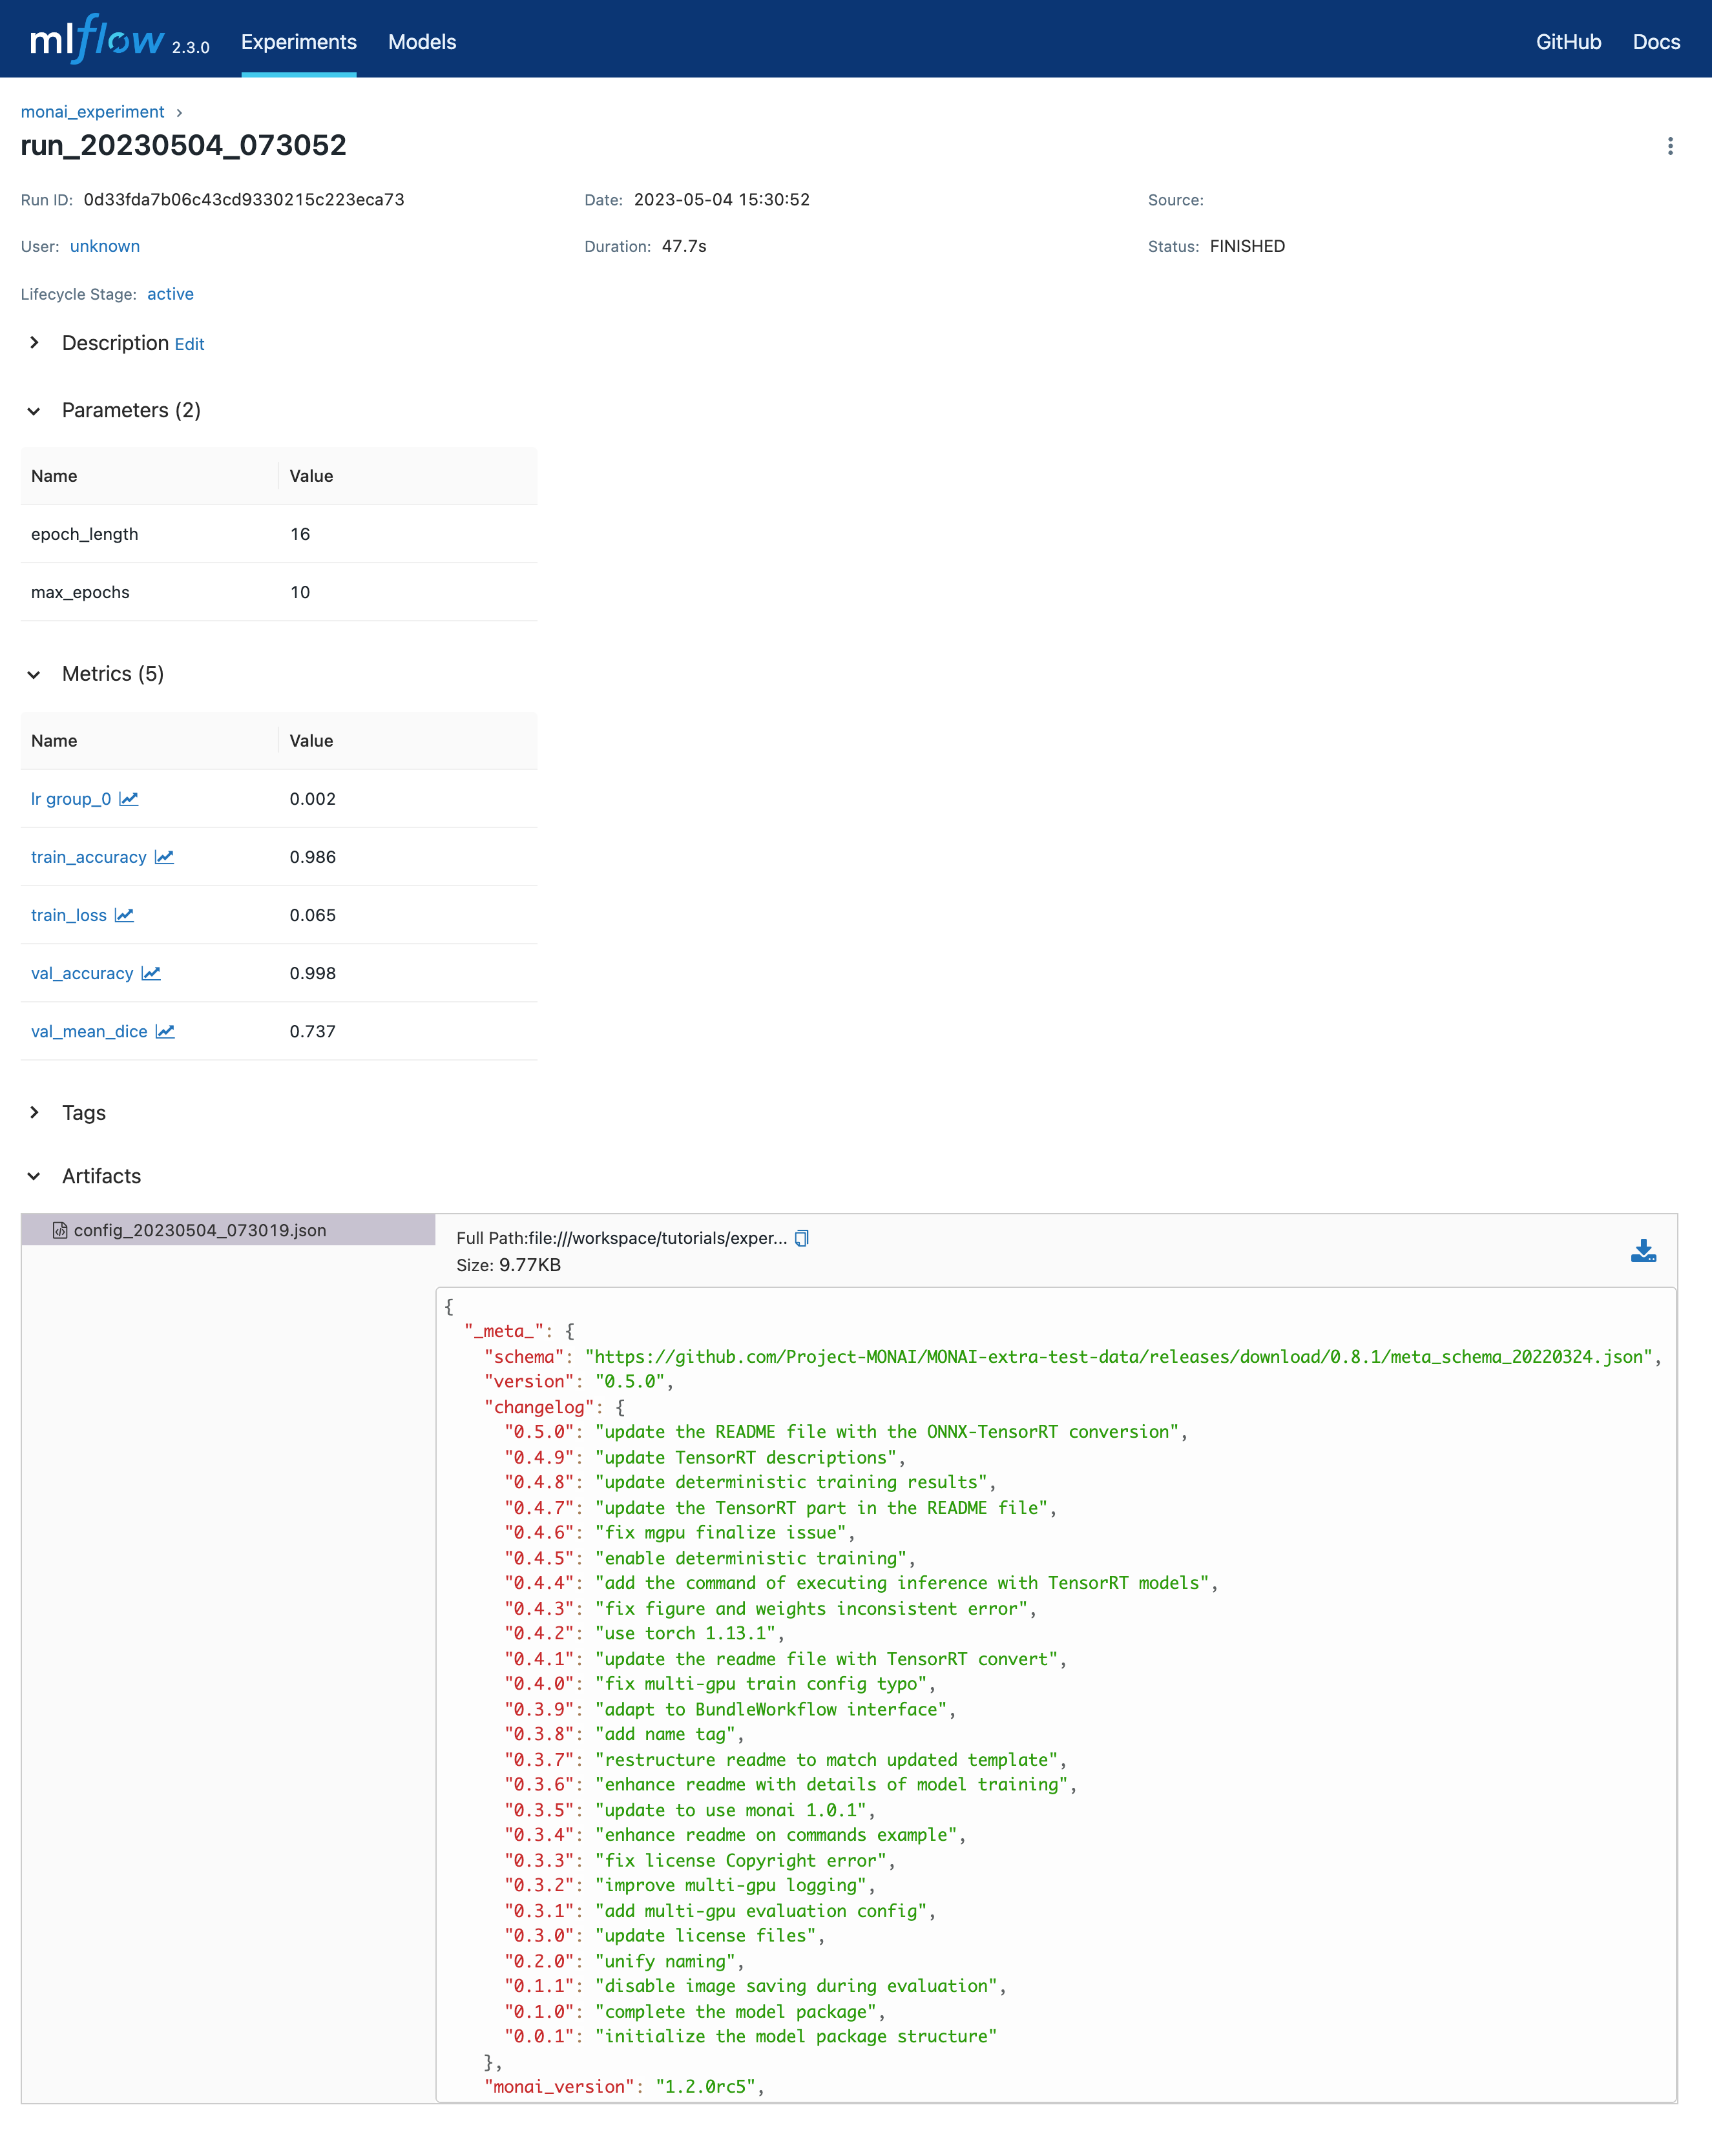
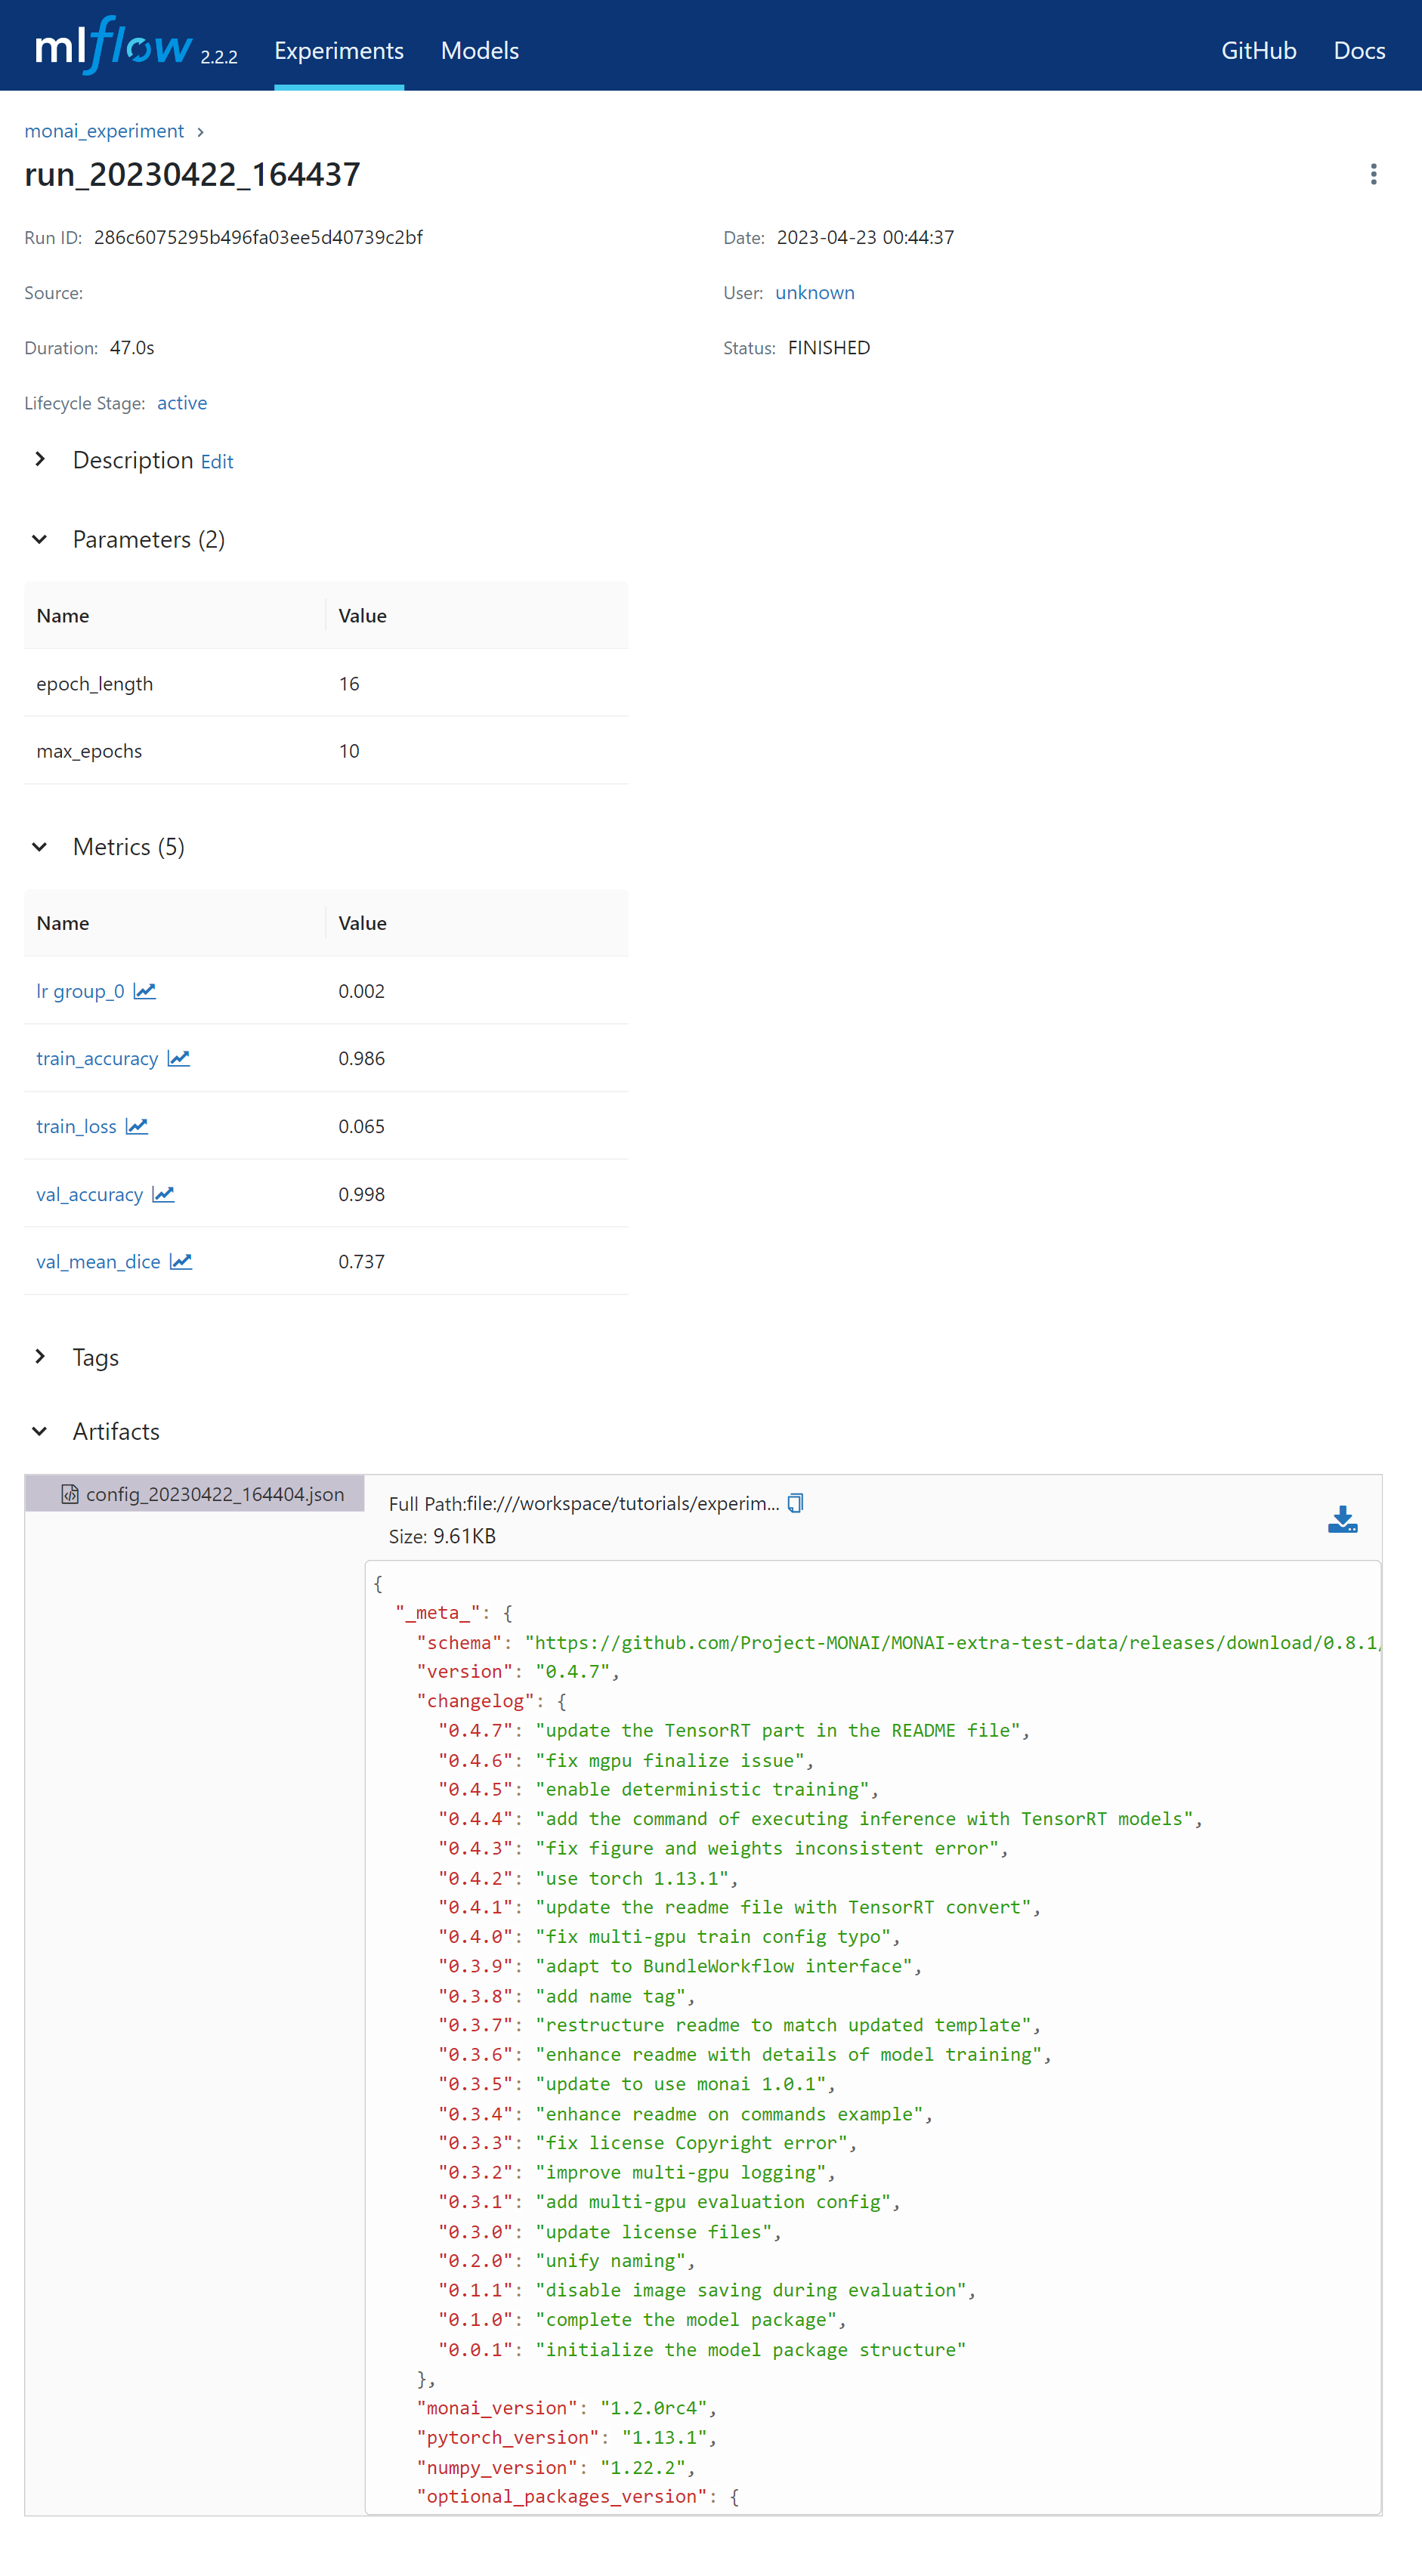

If parameters like `tracking_uri`, `experiment_name` and `run_name` were changed, the MLFlow log file folder and contents would also be changed. The command line in the next cell shows how to utilize these parameters. It only changed `experiment_name` and `run_name`. Although the `tracking_uri` is specified, it remains the same as the default one for convenience.

In [ ]:
%cd spleen_ct_segmentation
!python -m monai.bundle run \
    --config_file configs/train.json \
    --bundle_root ./ \
    --dataset_dir $MONAI_DATA_DIRECTORY/Task09_Spleen \
    --train#trainer#max_epochs 10 \
    --tracking "mlflow" \
    --tracking_uri ./eval/mlruns \
    --experiment_name "user_define_name" \
    --run_name "user_define_run"
%cd ..

The corresponding result of running above command is shown below. In the red box, the experiment and run name were changed according to input parameters.

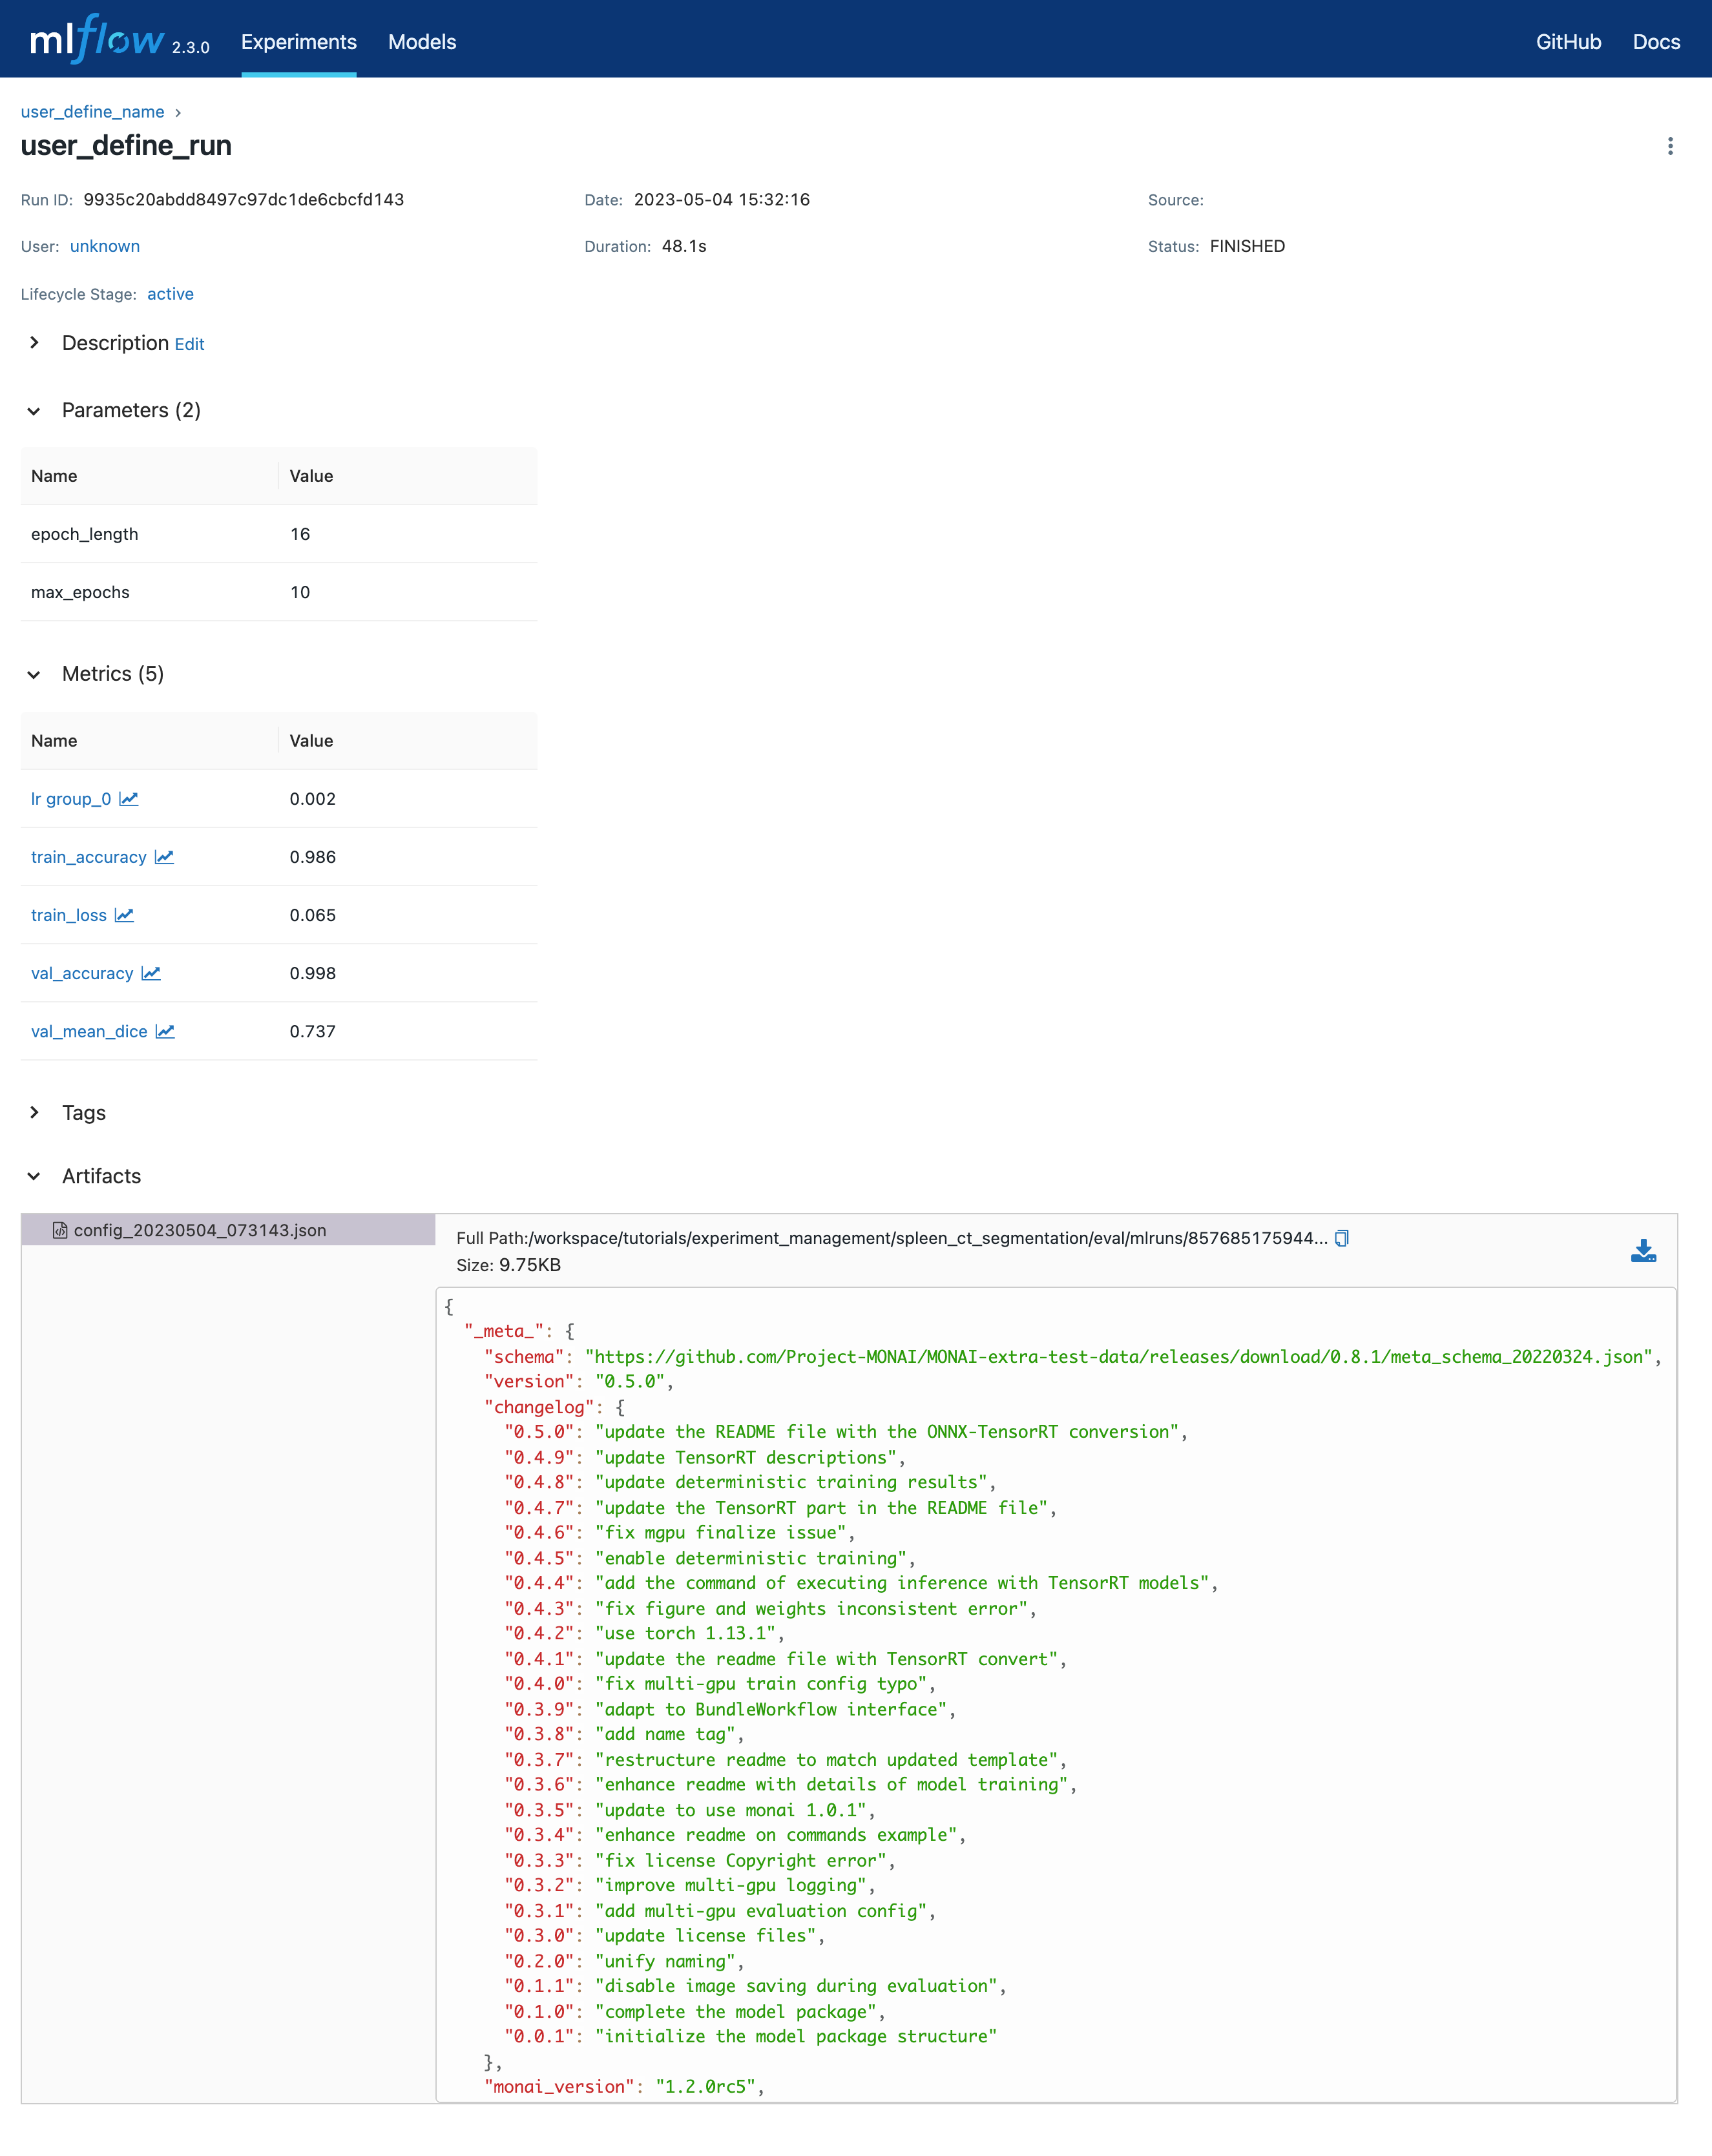

### Run spleen bundle with a MLflow settings JSON file

The other way to run MLflow with bundle is to pass a settings JSON file to `--tracking` parameter. In this file, a `mlflow_hander`, which is a handler to leverages MLflow in MONAI bundle, should be defined to enable tracking. More parameters and details can be added through this way. There is an example JSON named `mlflow_example.json` in this folder for reference. When writting the settings JSON file in multi-gpu environment, please note to use `_disabled_` parameter as shown in the example JSON to only enable MLflow in the first gpu.

In [ ]:
%cd spleen_ct_segmentation
!python -m monai.bundle run \
    --config_file configs/train.json \
    --bundle_root ./ \
    --dataset_dir $MONAI_DATA_DIRECTORY/Task09_Spleen \
    --train#trainer#max_epochs 10 \
    --tracking ../mlflow_example.json
%cd ..

As the experiment finished, it will be logged as shown below. And it is different from the default one by `run_name` and `parameters`, since we changed these in the settings JSON file.

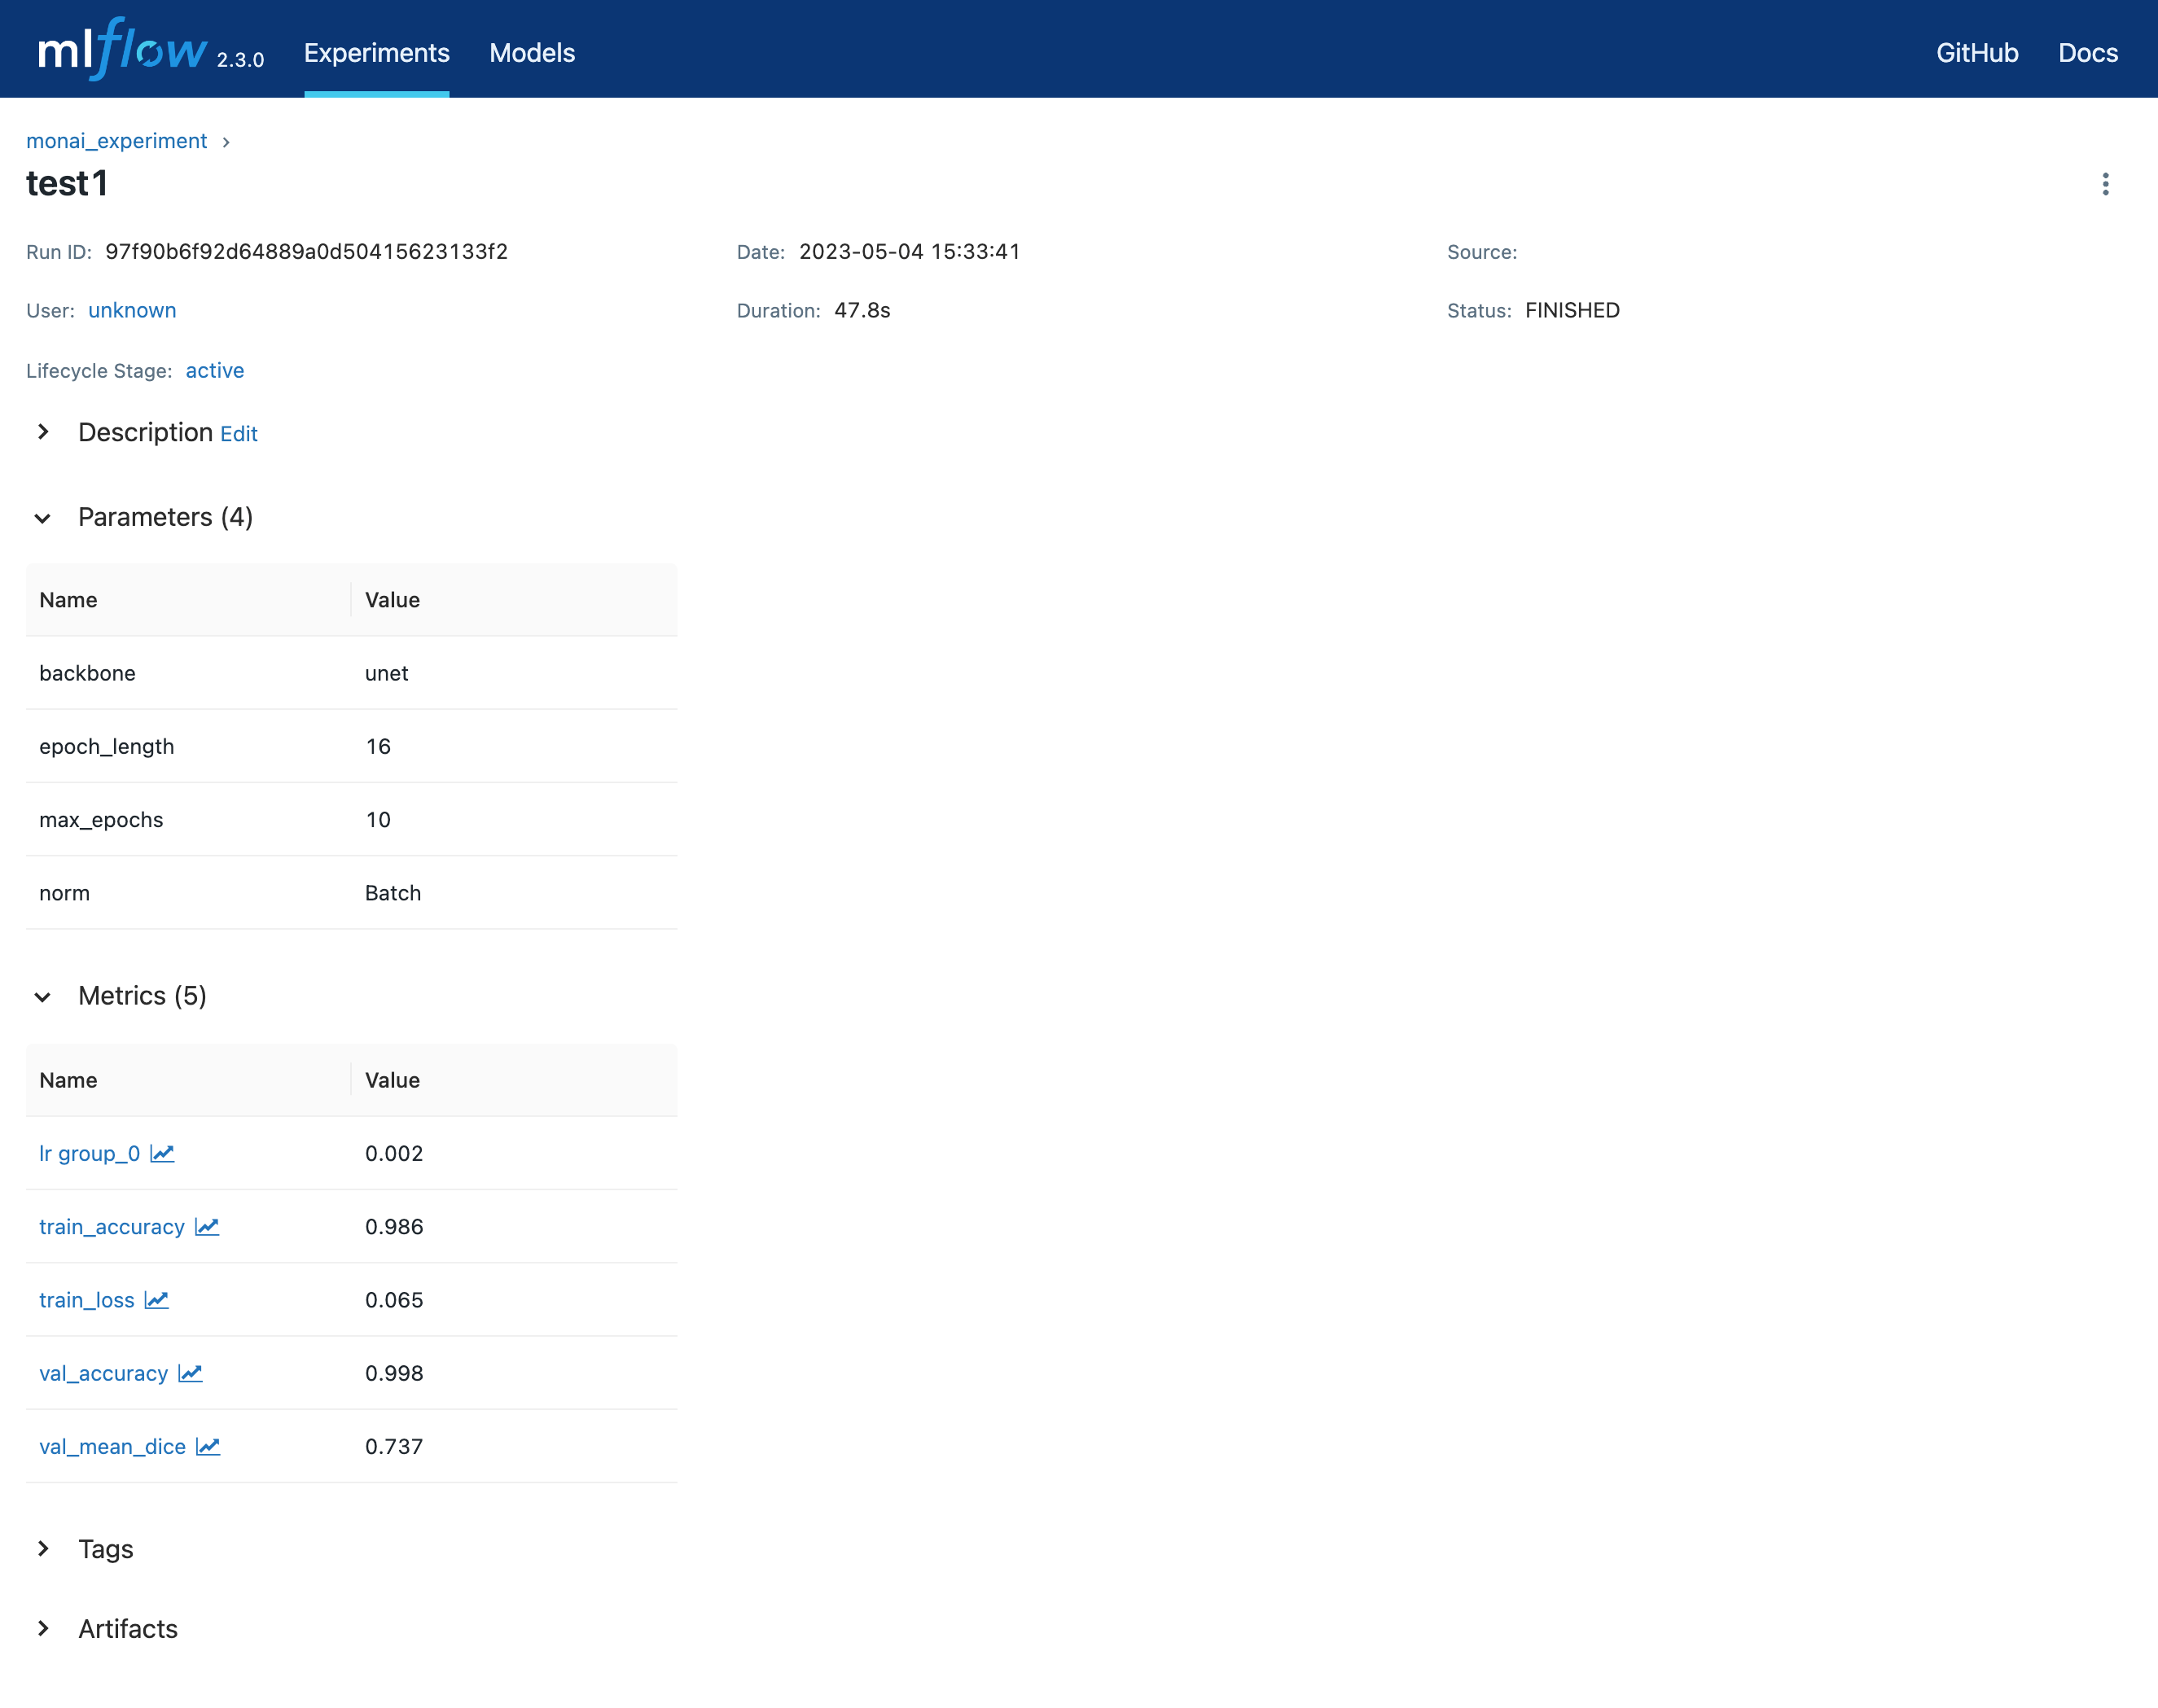
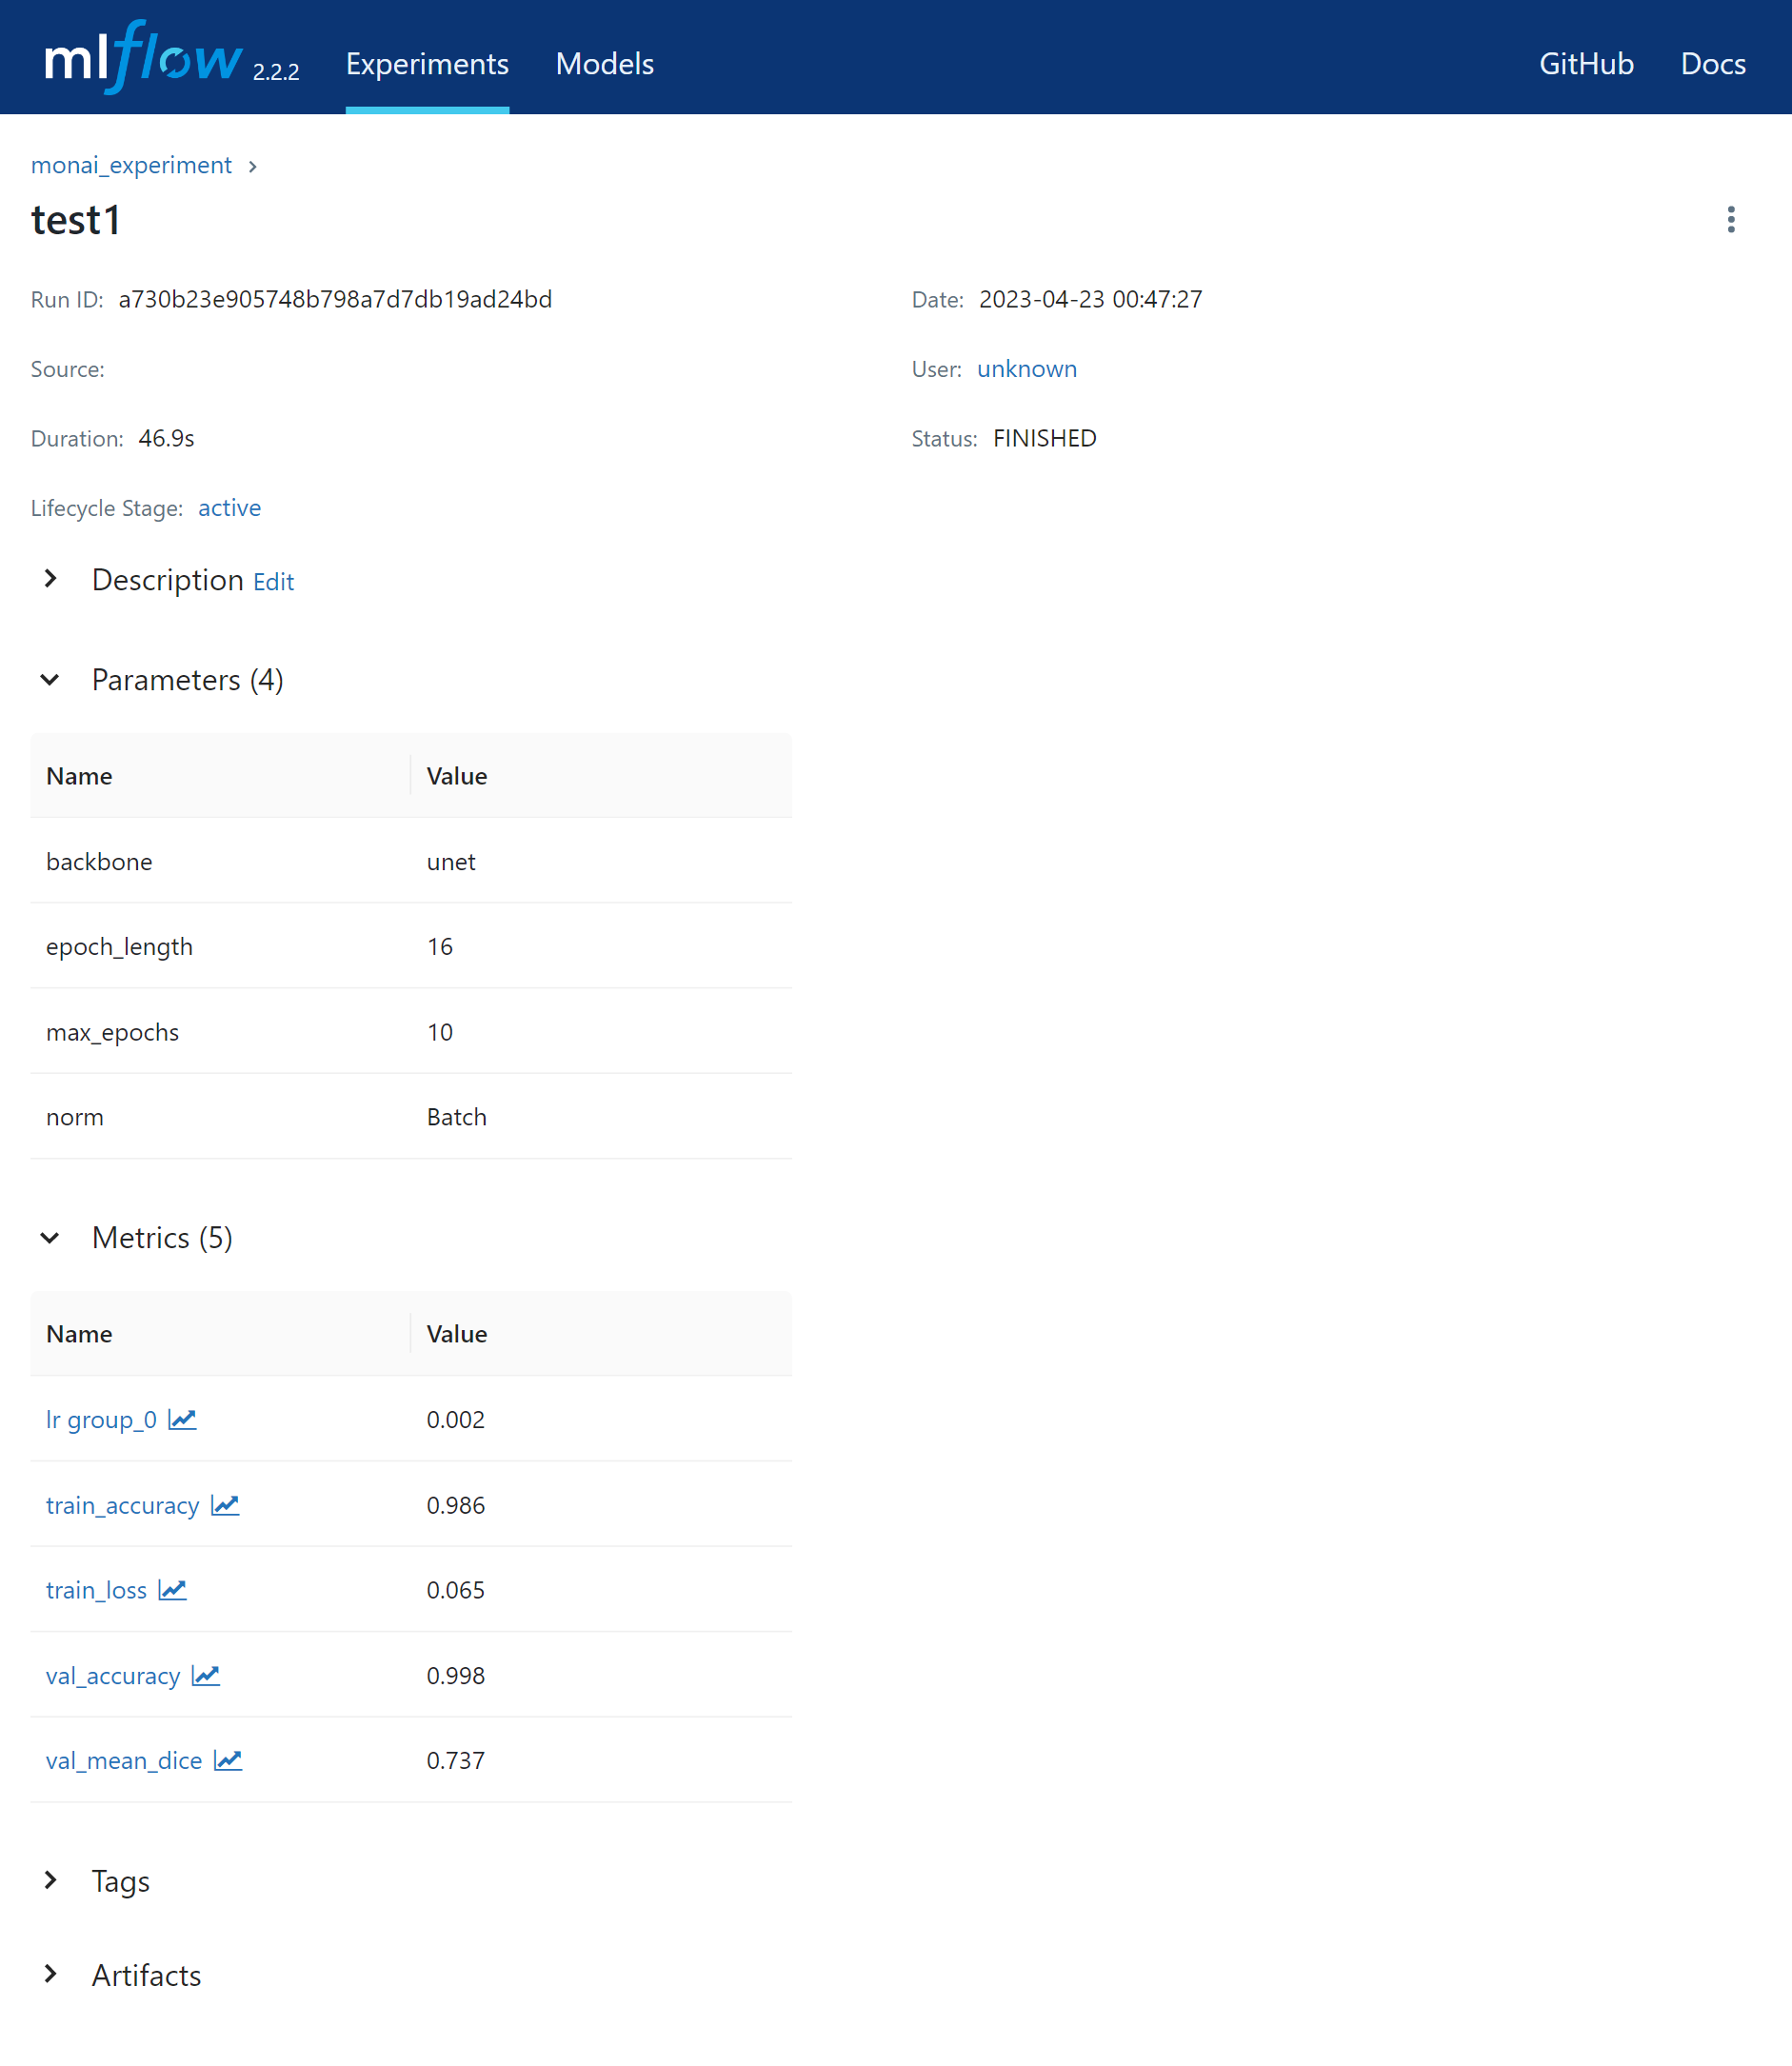

### Run spleen segmentation workflow with MLFlowHandler

In this part, we use the `ConfigWorkflow` from `monai.bundle` to show how to attach a `MLFlowHandler` to a monai engine in python code. However, users can also build their own workflow in python code and refer to this part to add the `MLFlowHandler`.

In [ ]:
%cd spleen_ct_segmentation
tracking_uri = "./eval/mlruns"
train_mlflow_handler = MLFlowHandler(
    tracking_uri=tracking_uri,
    experiment_name="ConfigWorkflowExperiment",
    run_name="ConfigWorkflowrun1",
    tag_name="train_loss",
    iteration_log=True,
    epoch_log=True,
    output_transform=monai.handlers.from_engine(["loss"], first=True),
    close_on_complete=True,
)
val_mlflow_handler = MLFlowHandler(
    tracking_uri=tracking_uri,
    experiment_name="ConfigWorkflowExperiment",
    run_name="ConfigWorkflowrun1",
    iteration_log=False,
)
workflow = ConfigWorkflow(
    workflow="train",
    config_file="./configs/train.json",
    meta_file="./configs/metadata.json",
    logging_file="./configs/logging.conf",
    init_id="initialize",
    run_id="run",
    final_id="finalize",
)
workflow.dataset_dir = data_dir
workflow.max_epochs = 10
workflow.initialize()
train_mlflow_handler.attach(workflow.trainer)
val_mlflow_handler.attach(workflow.evaluator)
workflow.run()
workflow.finalize()
%cd ..

The recorded results are shown below.

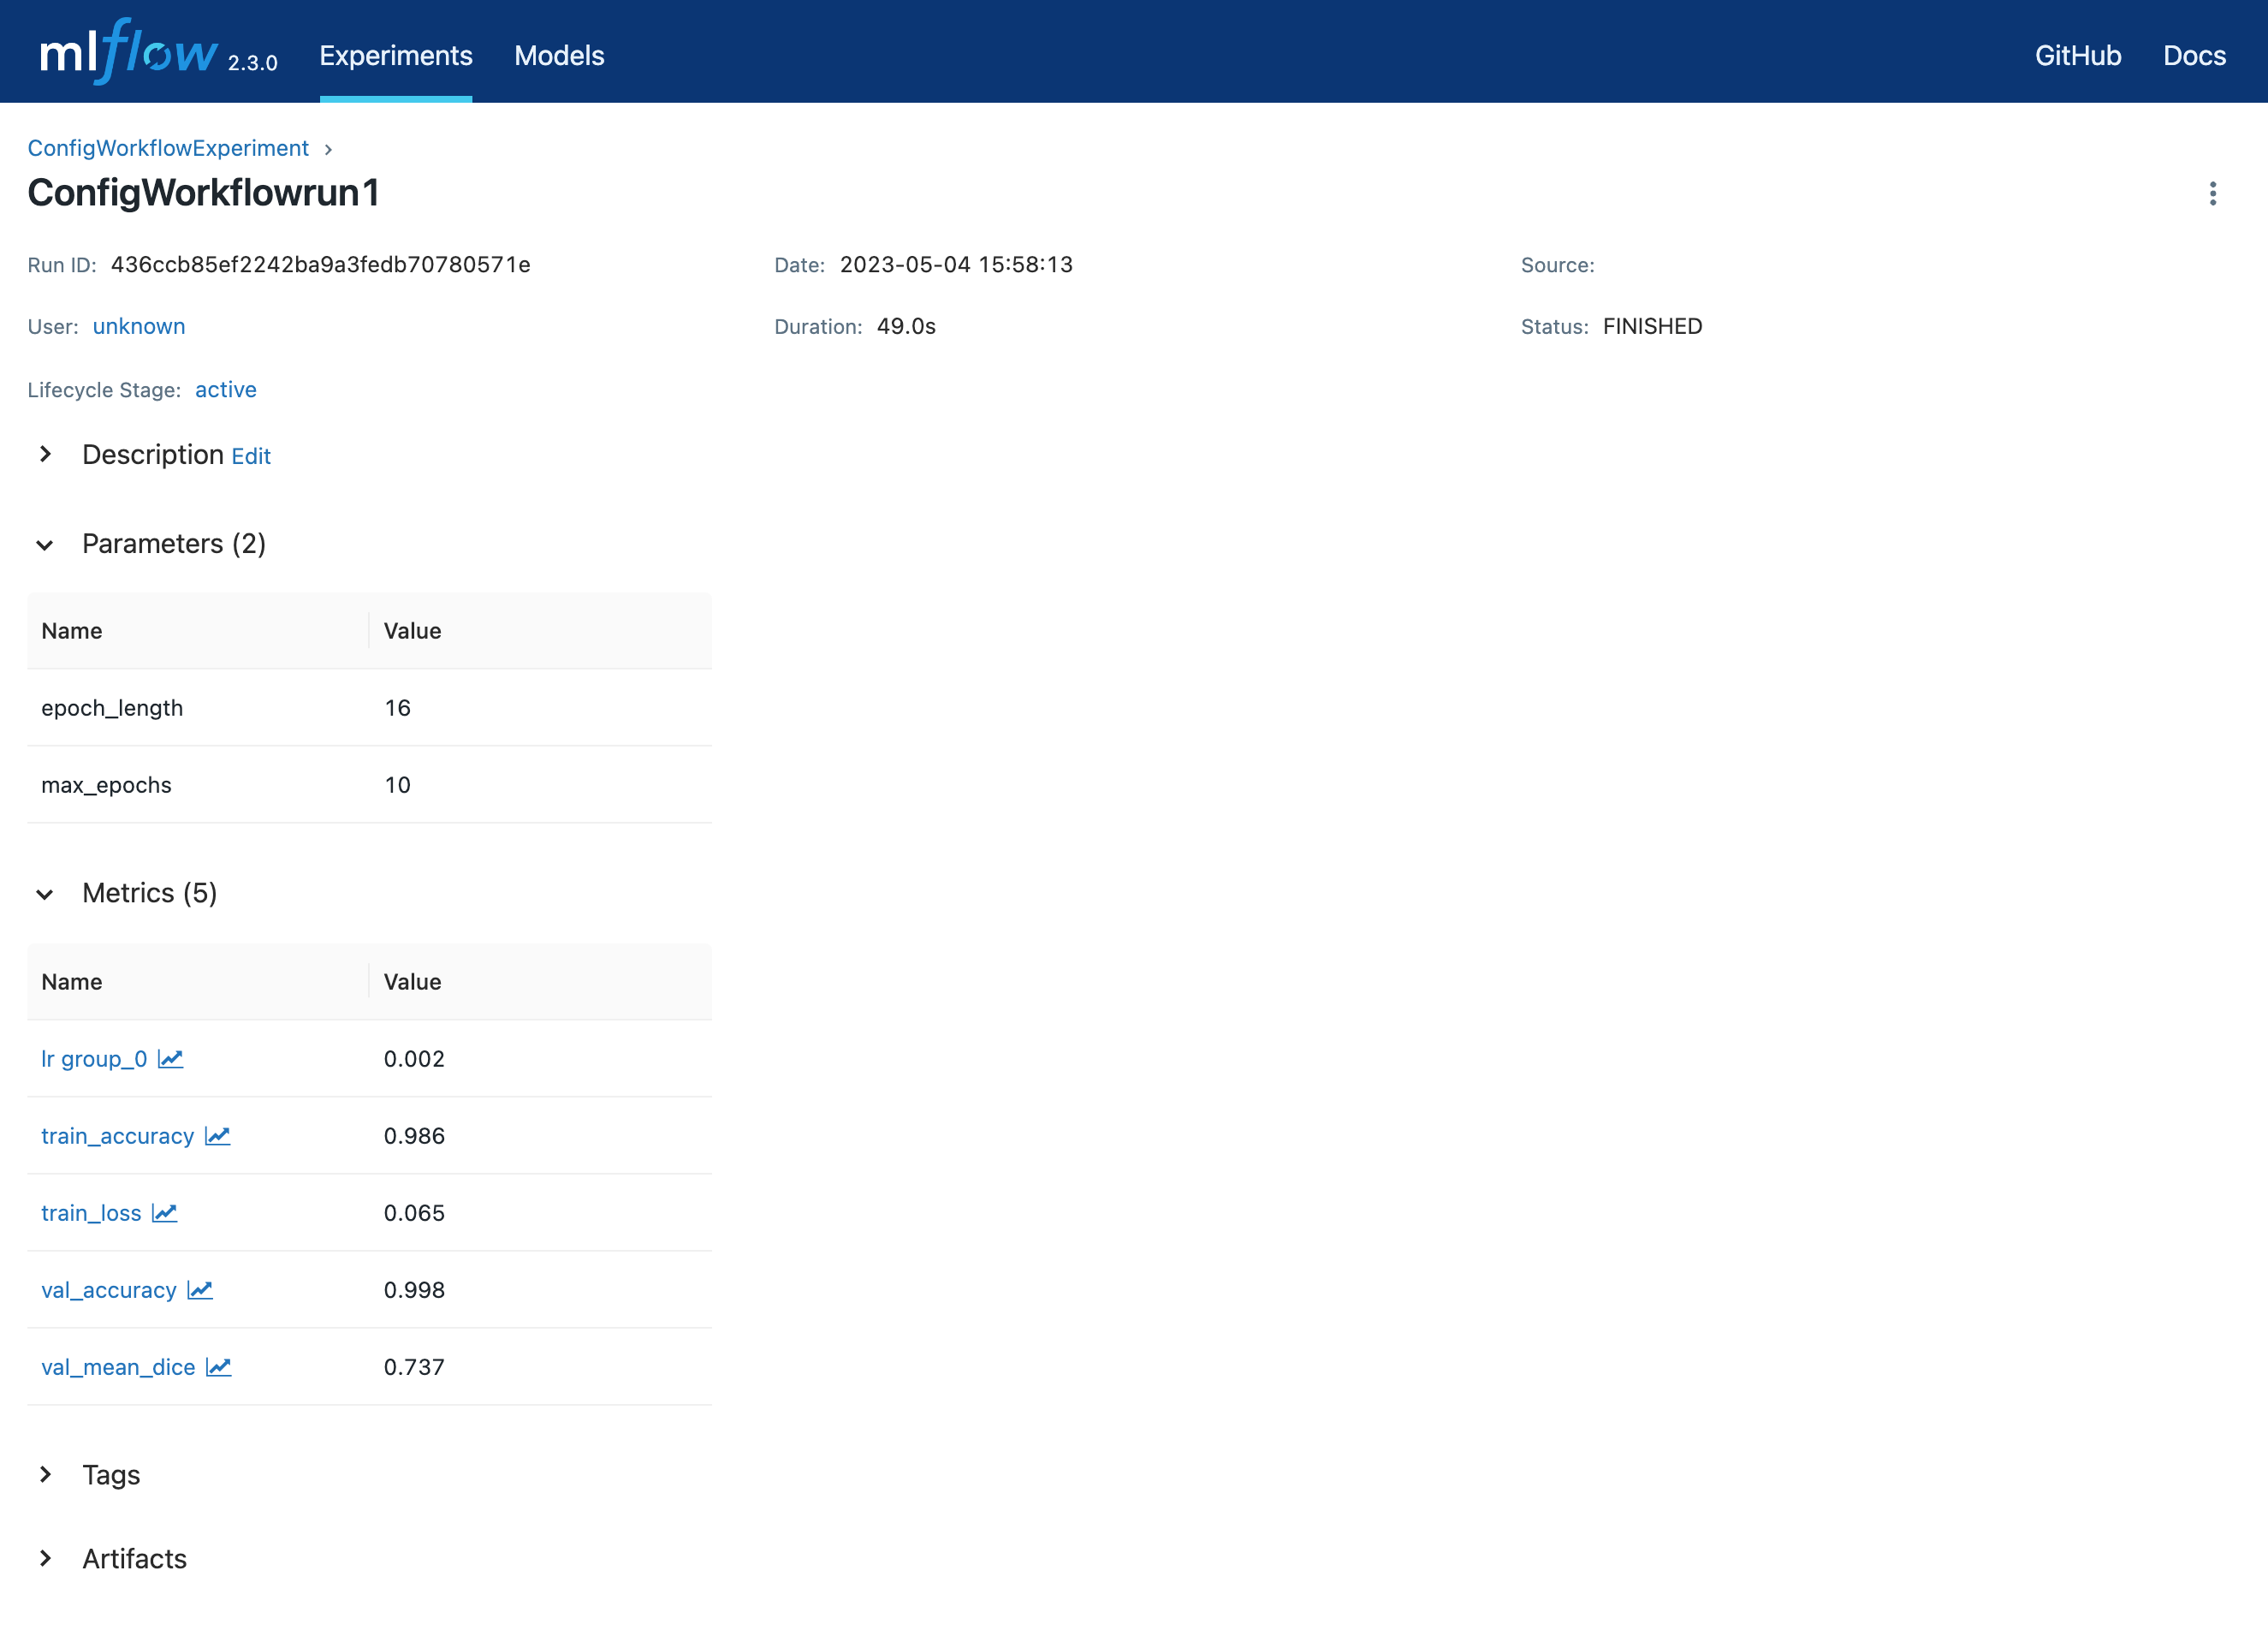